# Reference ET from BARRA data

In [1]:
import numpy as np
import time
import os
import matplotlib as plt
import sys
import glob
import dask
from dask.distributed import Client
import tempfile
import xarray as xr

sys.path.append('/g/data/mn51/users/dh4185/hazards-drought/ACS_eddi_et0/')
from pet_eddi import compute_daily_FAO56_PET, compute_EDDI

import warnings 
# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml


In [2]:
# Dask settings
dask.config.set({
    #'array.chunk-size': "256 MiB",
    #'array.slicing.split_large_chunks': True, 
    'distributed.comm.timeouts.connect': '120s',
    'distributed.comm.timeouts.tcp': '120s',
    'distributed.comm.retry.count': 10,
    'distributed.scheduler.allowed-failures': 20,
    "distributed.scheduler.worker-saturation": 1.1, #< This should use the new behaviour which helps with memory pile up
})

mem_lim = "252000mb" # 252000mb 63000mb
worker_n = 20

enc = {"ET0": {
        "zlib": True,
        "complevel": 1,
        "shuffle": True
        }
      }
       
client = Client(n_workers=worker_n, threads_per_worker=1, local_directory = tempfile.mkdtemp(), memory_limit = mem_lim)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that i

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 20
Total threads: 20,Total memory: 4.58 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46785,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:42459,Total threads: 1
Dashboard: /proxy/35061/status,Memory: 234.69 GiB
Nanny: tcp://127.0.0.1:42771,


2025-12-09 11:47:05,474 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 51ebf546d14ad1b31e0e696e8872f6a6 initialized by task ('rechunk-merge-rechunk-transfer-8f74940d5290b2e3db616d994951ee61', 0, 0, 0, 1, 0, 0) executed on worker tcp://127.0.0.1:44179
2025-12-09 11:47:07,173 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 51ebf546d14ad1b31e0e696e8872f6a6 deactivated due to stimulus 'task-finished-1765241227.1606867'
2025-12-09 11:47:15,268 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 51ebf546d14ad1b31e0e696e8872f6a6 initialized by task ('rechunk-merge-rechunk-transfer-8f74940d5290b2e3db616d994951ee61', 0, 0, 0, 1, 0, 0) executed on worker tcp://127.0.0.1:44179
2025-12-09 11:47:15,793 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 51ebf546d14ad1b31e0e696e8872f6a6 deactivated due to stimulus 'task-finished-1765241235.791438'


In [3]:
# client.close()

In [4]:
######################## Modify ##############################
startY = 1980
endY = 2025
freq = "day" # 'month' #'day'
root_dir = "/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/"
out_dir = "/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/BARRA-R2/"
lat_slice = slice(-38,-33)
lon_slice = slice(140,145)
chunks = {"time":366,"lat":300,"lon":300} #{"time":-1,"lat":20,"lon":20}

def preprocess_domain(ds,lat_slice,lon_slice):
    if lat_slice is None and lon_slice is None:
        return ds
    else:
        return ds.sel(lat=lat_slice,lon=lon_slice)

In [5]:
%%time

#< Read orography file
orog_file = "/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/fx/orog/latest/orog_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1.nc"
elev = xr.open_dataset(orog_file).orog

for year in range(startY,endY+1):
    print(year)
    print(f"==================== Processing {year-startY+1}/{len(range(startY,endY+1))} ====================")
    # Start the lap timer
    start_time = time.time()
    
    et_filename = f"{out_dir}ET0_FAO56_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_{year}01-{year}12.nc"
    print(et_filename)

    # Get files
    tasmax_files = glob.glob(f"{root_dir}tasmax/latest/tasmax_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_{year}*.nc")
    tasmax = xr.open_mfdataset(tasmax_files,
                               parallel=True,
                               preprocess=lambda ds: preprocess_domain(ds, lat_slice, lon_slice)).chunk(chunks)['tasmax']
    
    tasmin_files = glob.glob(f"{root_dir}tasmin/latest/tasmin_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_{year}*.nc")
    tasmin = xr.open_mfdataset(tasmin_files,
                               parallel=True,
                               preprocess=lambda ds: preprocess_domain(ds, lat_slice, lon_slice)).chunk(chunks)['tasmin']
    
    rsds_files = glob.glob(f"{root_dir}rsds/latest/rsds_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_{year}*.nc")
    rsds = xr.open_mfdataset(rsds_files,
                             parallel=True,
                             preprocess=lambda ds: preprocess_domain(ds, lat_slice, lon_slice)).chunk(chunks)['rsds']
    
    hurs_files = glob.glob(f"{root_dir}hurs/latest/hurs_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_{year}*.nc")
    hurs = xr.open_mfdataset(hurs_files,
                             parallel=True,
                             preprocess=lambda ds: preprocess_domain(ds, lat_slice, lon_slice)).chunk(chunks)['hurs']
    
    psl_files = glob.glob(f"{root_dir}psl/latest/psl_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_{year}*.nc")
    psl = xr.open_mfdataset(psl_files,
                            parallel=True,
                            preprocess=lambda ds: preprocess_domain(ds, lat_slice, lon_slice)).chunk(chunks)['psl']
    
    psl_files = glob.glob(f"{root_dir}psl/latest/psl_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_{year}*.nc")
    psl = xr.open_mfdataset(psl_files,
                            parallel=True,
                            preprocess=lambda ds: preprocess_domain(ds, lat_slice, lon_slice)).chunk(chunks)['psl']
    
    sfcWind_files = glob.glob(f"{root_dir}sfcWind/latest/sfcWind_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_{year}*.nc")
    sfcWind = xr.open_mfdataset(sfcWind_files,
                                parallel=True,
                                preprocess=lambda ds: preprocess_domain(ds, lat_slice, lon_slice)).chunk(chunks)['sfcWind']

    ET = compute_daily_FAO56_PET(
        tasmax=tasmax,
        tasmin=tasmin,
        rsds=rsds,
        hurs=hurs,
        sfcWind=sfcWind,
        psl=psl,
        elev=elev,
        crop="short",
        freq="day",
        et_filename=et_filename,
    )
    
    # End the timer
    print(f"Time taken: {(time.time()- start_time):.2f} seconds")

1980
==================== Processing 1/46 ====================
/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/BARRA-R2/ET0_FAO56_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_198001-198012.nc
----- Start calculation ... -----
Converting temperature from K to C.
Converting temperature from K to C.
Time taken: 78.12 seconds
1981
==================== Processing 2/46 ====================
/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/BARRA-R2/ET0_FAO56_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_198101-198112.nc
----- Start calculation ... -----
Converting temperature from K to C.
Converting temperature from K to C.
Time taken: 25.22 seconds
1982
==================== Processing 3/46 ====================
/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/BARRA-R2/ET0_FAO56_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_198201-198212.nc
----- Start calculation ... -----
Convertin

# EDDI calculation

In [3]:
%%time
indir = "/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/BARRA-R2/"
outdir = "/g/data/mn51/projects/work_package_4/climate_hazard_indices/drought/native/EDDI/BOM/"
files = sorted(glob.glob(f"{indir}ET0_FAO56_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_*.nc"))

ds_ET0 = xr.open_mfdataset(files, parallel=True)
ds_ET0 = ds_ET0.chunk({"time":-1,"lat":20,"lon":20})
ds_ET0

CPU times: user 5.39 s, sys: 2.33 s, total: 7.72 s
Wall time: 15.3 s


<xarray.Dataset> Size: 138MB
Dimensions:  (time: 16649, lat: 46, lon: 45)
Coordinates:
  * time     (time) datetime64[ns] 133kB 1980-01-01T12:00:00 ... 2025-07-31T1...
  * lat      (lat) float64 368B -37.95 -37.84 -37.73 ... -33.22 -33.11 -33.0
  * lon      (lon) float64 360B 140.1 140.2 140.3 140.4 ... 144.7 144.8 144.9
Data variables:
    ET0      (time, lat, lon) float32 138MB dask.array<chunksize=(16649, 20, 20), meta=np.ndarray>
Attributes:
    author:   David Hoffmann
    contact:  david.hoffmann@bom.gov.au
    source:   Derived from tasmax, tasmin, rsds, hurs, wind, psl, orog

In [4]:
%%time
_ndays=30
compute_EDDI(
    ds_ET0.ET0,
    ndays=_ndays,
    compute_categories=True,
    outdir=outdir,
    filename = f"EDDI_{_ndays}day_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day"
    )


Writing 1980...
Writing 1981...
Writing 1982...
Writing 1983...
Writing 1984...
Writing 1985...
Writing 1986...
Writing 1987...
Writing 1988...
Writing 1989...
Writing 1990...
Writing 1991...
Writing 1992...
Writing 1993...
Writing 1994...
Writing 1995...
Writing 1996...
Writing 1997...
Writing 1998...
Writing 1999...
Writing 2000...
Writing 2001...
Writing 2002...
Writing 2003...
Writing 2004...
Writing 2005...
Writing 2006...
Writing 2007...
Writing 2008...
Writing 2009...
Writing 2010...
Writing 2011...
Writing 2012...
Writing 2013...
Writing 2014...
Writing 2015...
Writing 2016...
Writing 2017...
Writing 2018...
Writing 2019...
Writing 2020...
Writing 2021...
Writing 2022...
Writing 2023...
Writing 2024...
Writing 2025...
Done.
CPU times: user 31 s, sys: 6.63 s, total: 37.6 s
Wall time: 48.5 s


<xarray.DataArray 'ET0' (time: 16608, lat: 46, lon: 45)> Size: 138MB
dask.array<where, shape=(16608, 46, 45), dtype=float32, chunksize=(45, 46, 45), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 133kB 1980-01-30T12:00:00 ... 2025-07-31T1...
  * lat      (lat) float64 368B -37.95 -37.84 -37.73 ... -33.22 -33.11 -33.0
  * lon      (lon) float64 360B 140.1 140.2 140.3 140.4 ... 144.7 144.8 144.9
    year     (time) int64 133kB 1980 1980 1980 1980 1980 ... 2025 2025 2025 2025
    doy      (time) int64 133kB 30 31 32 33 34 35 36 ... 207 208 209 210 211 212

In [5]:
eddi = xr.open_mfdataset(glob.glob(f"{outdir}EDDI_30day_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_*.nc"))#.sel(lat=lat_slice,lon=lon_slice)
eddi

<xarray.Dataset> Size: 275MB
Dimensions:   (time: 16608, lat: 46, lon: 45)
Coordinates:
  * time      (time) datetime64[ns] 133kB 1980-01-30T12:00:00 ... 2025-07-31T...
  * lat       (lat) float64 368B -37.95 -37.84 -37.73 ... -33.22 -33.11 -33.0
  * lon       (lon) float64 360B 140.1 140.2 140.3 140.4 ... 144.7 144.8 144.9
Data variables:
    EDDI      (time, lat, lon) float32 138MB dask.array<chunksize=(336, 46, 45), meta=np.ndarray>
    EDDI_cat  (time, lat, lon) float32 138MB dask.array<chunksize=(336, 46, 45), meta=np.ndarray>

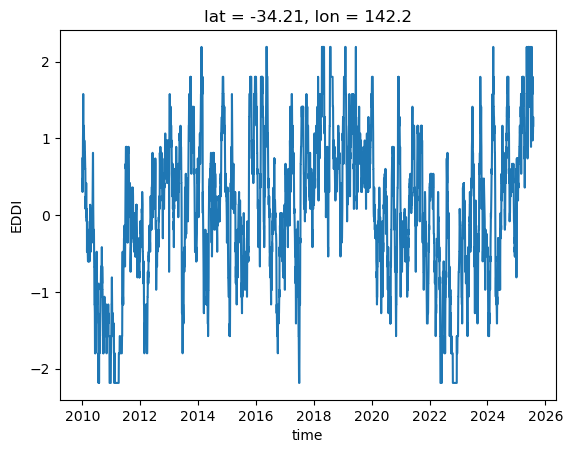

In [10]:
eddi.EDDI.sel(lat=-34.21,lon=142.14, method="nearest").sel(time=slice("2010","2025")).plot()

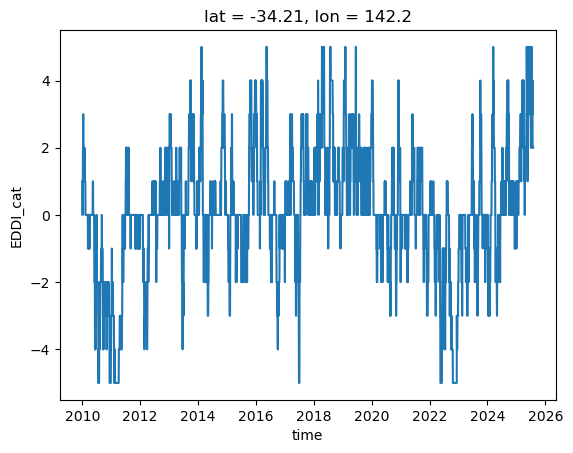

In [12]:
eddi.EDDI_cat.sel(lat=-34.21,lon=142.14, method="nearest").sel(time=slice("2010","2025")).plot()